VAL thresholds used:
  ATTO:   0.464225
  NANO:   0.500000  (seeds 0)
  HYBRID: 0.500000


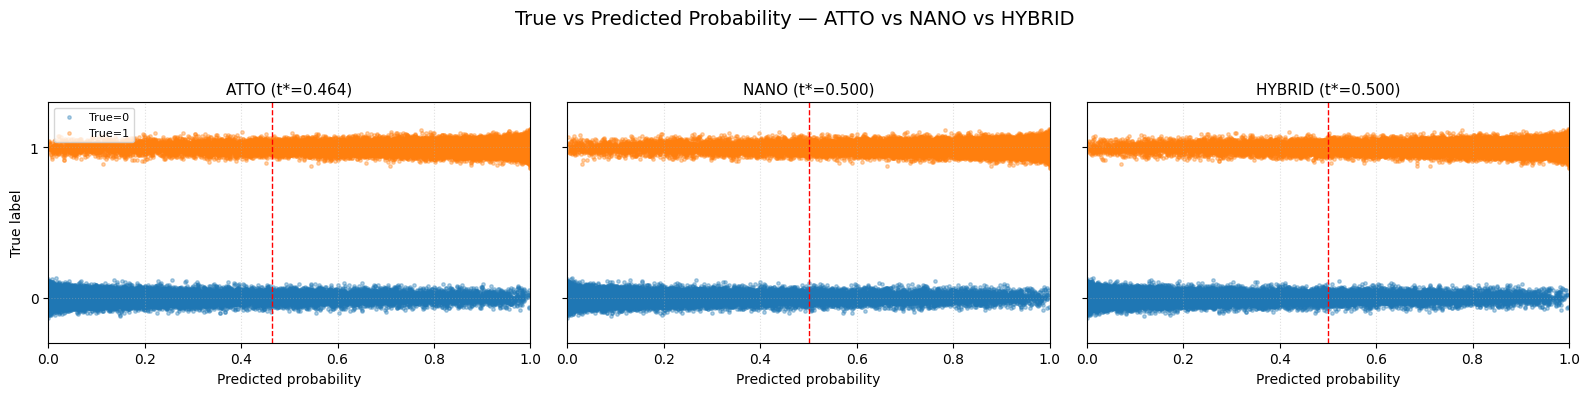

In [2]:
# ======================================================================
# 1) Load everything (threshold, CSV) + True-vs-Pred 1×3 visualization
# ======================================================================

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, roc_curve,
                             average_precision_score, confusion_matrix)

# ===== USER INPUT =====
ATTO_CSV = "/home/users/mmingyeong/2508_slchallence/res/test_eval_test_eval_20250918_164437/test_ens_labeled.csv"
ATTO_METRICS_JSON = "/home/users/mmingyeong/2508_slchallence/res/eval_val_ensemble/metrics_val_ens.json"

NANO_CSV = "/home/users/mmingyeong/2508_slchallence/res/nano_ckpt/test_eval_test_eval_20251005_173517/test_ens_labeled.csv"
NANO_METRICS = [
    "/home/users/mmingyeong/2508_slchallence/res/_full_ckpt_fulltrain_nano_s42_20250925_184205_pred_val_pred_20251005_132054/eval_val_ensemble/metrics_val_ens.json",
    "/home/users/mmingyeong/2508_slchallence/res/_full_ckpt_fulltrain_nano_s101_20250925_184206_pred_val_pred_20251005_132054/eval_val_ensemble/metrics_val_ens.json",
    "/home/users/mmingyeong/2508_slchallence/res/_full_ckpt_fulltrain_nano_s202_20250927_134111_pred_val_pred_20251005_132054/eval_val_ensemble/metrics_val_ens.json",
    "/home/users/mmingyeong/2508_slchallence/res/_full_ckpt_fulltrain_nano_s303_20250927_191302_pred_val_pred_20251005_132054/eval_val_ensemble/metrics_val_ens.json",
    "/home/users/mmingyeong/2508_slchallence/res/_full_ckpt_fulltrain_nano_s404_20250929_150029_pred_val_pred_20251005_132054/eval_val_ensemble/metrics_val_ens.json",
]

HYBRID_RUN_DIR = "/home/users/mmingyeong/2508_slchallence/res/ensemble_hybrid_test_test_eval_20251005_180739"
HYBRID_CSV = f"{HYBRID_RUN_DIR}/test_ens_labeled.csv"
HYBRID_TSTAR_FILE = f"{HYBRID_RUN_DIR}/ensemble_hybrid_val/threshold.txt"
HYBRID_METRICS_JSON = f"{HYBRID_RUN_DIR}/ensemble_hybrid_val/metrics_val_ens_hybrid.json"

AGG_MODE = "mean"   # for NANO seeds: "mean" or "median"


# ===============================================================
# Threshold extraction helpers
# ===============================================================
def _extract_threshold(json_path):
    """Extract t* from metrics JSON if possible."""
    try:
        with open(json_path) as f:
            m = json.load(f)

        # common places
        if isinstance(m, dict):
            if "global" in m and "threshold" in m["global"]:
                return float(m["global"]["threshold"])
            if "threshold" in m:
                t = float(m["threshold"])
                if 0.0 <= t <= 1.0:
                    return t

            # deep scan
            def scan(v):
                if isinstance(v, dict):
                    for vv in v.values():
                        out = scan(vv)
                        if out is not None:
                            return out
                elif isinstance(v, (int, float)) and 0 <= v <= 1:
                    return float(v)
                return None
            return scan(m)

    except Exception:
        pass

    return None


def load_val_threshold_list(metrics_list, agg="mean", fallback=0.5):
    """Load t* from seed JSON files."""
    vals = []
    for p in metrics_list:
        if os.path.isfile(p):
            t = _extract_threshold(p)
            if t is not None:
                vals.append(t)

    if not vals:
        return fallback, []

    arr = np.asarray(vals, float)
    thr = float(np.mean(arr) if agg == "mean" else np.median(arr))
    return thr, vals


# ===============================================================
# 2) Thresholds
# ===============================================================
thr_atto = _extract_threshold(ATTO_METRICS_JSON) if os.path.isfile(ATTO_METRICS_JSON) else 0.5
thr_nano, nano_thr_list = load_val_threshold_list(NANO_METRICS, agg=AGG_MODE, fallback=0.5)

# HYBRID: threshold.txt 우선
if os.path.isfile(HYBRID_TSTAR_FILE):
    with open(HYBRID_TSTAR_FILE) as f:
        thr_hybrid = float(f.read().strip())
else:
    thr_hybrid = _extract_threshold(HYBRID_METRICS_JSON) if os.path.isfile(HYBRID_METRICS_JSON) else 0.5


print("VAL thresholds used:")
print(f"  ATTO:   {thr_atto:.6f}")
print(f"  NANO:   {thr_nano:.6f}  (seeds {len(nano_thr_list)})")
print(f"  HYBRID: {thr_hybrid:.6f}")


# ===============================================================
# 3) Plot — True vs Predicted Probability (1×3)
# ===============================================================

def load_labels_probs(csv_path):
    df = pd.read_csv(csv_path, usecols=["label", "prob"])
    y = pd.to_numeric(df["label"]).round().astype(int).to_numpy()
    p = pd.to_numeric(df["prob"]).to_numpy()
    return y, p


def plot_true_vs_pred_prob(ax, csv_path, thr, title):
    """Draw one subplot showing true label vs predicted probability."""

    y, p = load_labels_probs(csv_path)

    # jitter for nicer visualization
    rng = np.random.default_rng(123)
    jitter0 = rng.normal(0, 0.03, size=(y == 0).sum())
    jitter1 = rng.normal(0, 0.03, size=(y == 1).sum())

    # plot
    ax.scatter(p[y == 0], 0 + jitter0, s=6, alpha=0.35, label="True=0")
    ax.scatter(p[y == 1], 1 + jitter1, s=6, alpha=0.35, label="True=1")

    # threshold line
    ax.axvline(thr, color="red", linestyle="--", linewidth=1)

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.3, 1.3)
    ax.set_yticks([0, 1])
    ax.set_xlabel("Predicted probability")
    ax.set_title(title, fontsize=11)
    ax.grid(True, linestyle=":", alpha=0.4)


# ---- visualize 1x3 figure ----
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

plot_true_vs_pred_prob(axes[0], ATTO_CSV,   thr_atto,   f"ATTO (t*={thr_atto:.3f})")
plot_true_vs_pred_prob(axes[1], NANO_CSV,   thr_nano,   f"NANO (t*={thr_nano:.3f})")
plot_true_vs_pred_prob(axes[2], HYBRID_CSV, thr_hybrid, f"HYBRID (t*={thr_hybrid:.3f})")

axes[0].set_ylabel("True label")
axes[0].legend(loc="upper left", fontsize=8, frameon=True)

plt.suptitle("True vs Predicted Probability — ATTO vs NANO vs HYBRID", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


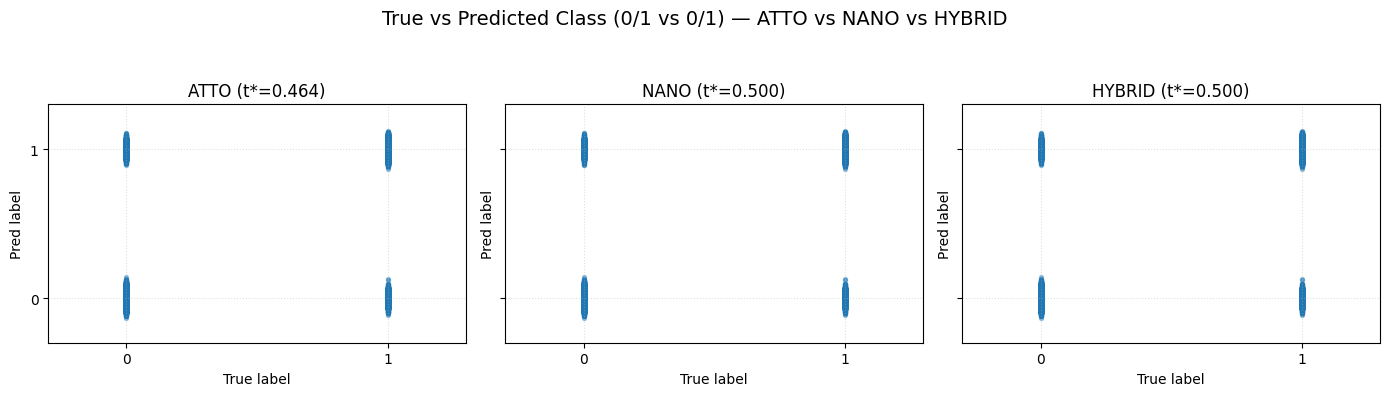

In [3]:
# ================================
# True-vs-Pred Scatter (0/1 vs 0/1)
# ================================
import pandas as pd
import matplotlib.pyplot as plt

def load_true_pred(csv_path, thr):
    df = pd.read_csv(csv_path, usecols=["label", "prob"])
    y = df["label"].round().astype(int).to_numpy()
    p = df["prob"].to_numpy()
    yhat = (p >= thr).astype(int)
    return y, yhat

def plot_true_vs_pred(ax, y, yhat, title):
    # jitter for visualization
    import numpy as np
    rng = np.random.default_rng(0)
    jitter = rng.normal(0, 0.03, size=len(y))

    ax.scatter(y, yhat + jitter, s=8, alpha=0.4)

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xlabel("True label")
    ax.set_ylabel("Pred label")
    ax.set_title(title)
    ax.grid(True, linestyle=":", alpha=0.4)
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-0.3, 1.3)


# load
y_atto, yhat_atto = load_true_pred(ATTO_CSV, thr_atto)
y_nano, yhat_nano = load_true_pred(NANO_CSV, thr_nano)
y_hybrid, yhat_hybrid = load_true_pred(HYBRID_CSV, thr_hybrid)

# figure
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

plot_true_vs_pred(axes[0], y_atto, yhat_atto, f"ATTO (t*={thr_atto:.3f})")
plot_true_vs_pred(axes[1], y_nano, yhat_nano, f"NANO (t*={thr_nano:.3f})")
plot_true_vs_pred(axes[2], y_hybrid, yhat_hybrid, f"HYBRID (t*={thr_hybrid:.3f})")

plt.suptitle("True vs Predicted Class (0/1 vs 0/1) — ATTO vs NANO vs HYBRID", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.92])
plt.show()


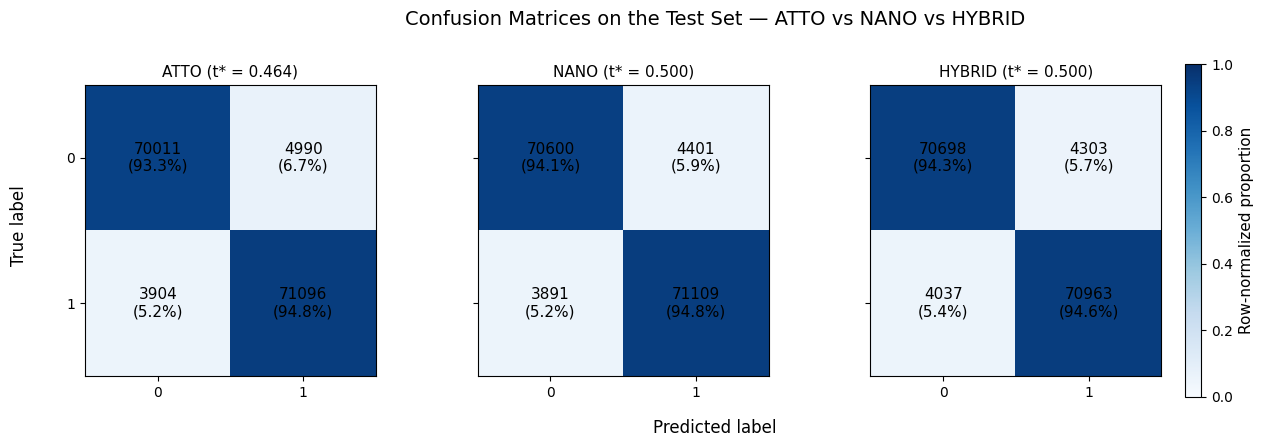

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---------- helpers ----------
def load_true_pred(csv_path, thr):
    df = pd.read_csv(csv_path, usecols=["label", "prob"])
    y_true = df["label"].round().astype(int).to_numpy()
    y_prob = df["prob"].to_numpy()
    y_pred = (y_prob >= thr).astype(int)
    return y_true, y_pred

def plot_conf_mat(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)  # [[TN, FP],[FN, TP]]
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    im = ax.imshow(cm_norm, vmin=0.0, vmax=1.0, cmap="Blues")

    for (i, j), v in np.ndenumerate(cm):
        ax.text(
            j, i,
            f"{v}\n({cm_norm[i, j]*100:.1f}%)",
            ha="center", va="center", fontsize=11
        )

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["0", "1"])
    ax.set_yticklabels(["0", "1"])
    ax.set_title(title, fontsize=11)
    ax.grid(False)

    return im

# ---------- load data ----------
y_atto,   yhat_atto   = load_true_pred(ATTO_CSV,   thr_atto)
y_nano,   yhat_nano   = load_true_pred(NANO_CSV,   thr_nano)
y_hybrid, yhat_hybrid = load_true_pred(HYBRID_CSV, thr_hybrid)

# ---------- figure ----------
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), sharey=True)

im0 = plot_conf_mat(axes[0], y_atto,   yhat_atto,
                    f"ATTO (t* = {thr_atto:.3f})")
im1 = plot_conf_mat(axes[1], y_nano,   yhat_nano,
                    f"NANO (t* = {thr_nano:.3f})")
im2 = plot_conf_mat(axes[2], y_hybrid, yhat_hybrid,
                    f"HYBRID (t* = {thr_hybrid:.3f})")

# 축 공통 레이블
fig.text(0.5, 0.04, "Predicted label", ha="center", fontsize=12)
fig.text(0.03, 0.5, "True label", va="center", rotation="vertical", fontsize=12)

plt.suptitle("Confusion Matrices on the Test Set — ATTO vs NANO vs HYBRID", fontsize=14)

# subplot 영역 먼저 정리 (오른쪽 일부는 colorbar용으로 남겨두기)
plt.subplots_adjust(left=0.08, right=0.86, bottom=0.12, top=0.86, wspace=0.35)

# 오른쪽에 세 패널 공통 colorbar
cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), location="right", fraction=0.06, pad=0.02)
cbar.set_label("Row-normalized proportion", fontsize=11)

plt.show()
